## Imports and Set up


In [75]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# df = pd.read_csv("../data/flocking_250305.csv")
df = pd.read_csv("../mesa/flocking_250418_v1.csv")
# df_1 = pd.read_csv("flocking_250409_v1.csv")
# df_2 = pd.read_csv("flocking_250409_v2.csv")
# df_3 = pd.read_csv("flocking_250409_v3.csv")
# df = pd.concat([df_1, df_2, df_3], ignore_index=True)
# print(f"Number of rows in df: {len(df)}")

Using device: cpu


In [76]:
df.head()

,Step,AgentID,Angle,Vision,Separation,CohereFactor,SeparateFactor,MatchFactor,NeighborDiffSum,NeighborInfo,run
0,1,1,1.937776,10,2,0.03,0.015,0.05,"[0, 0]","[1.9377761573236025, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,1,2,4.489234,10,2,0.03,0.015,0.05,"[2.52815968906571, 6.4411154129569255]","[4.489234097788165, 2.52815968906571, 6.441115...",0
2,1,3,5.236482,10,2,0.03,0.015,0.05,"[0, 0]","[5.236482138917429, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",0
3,1,4,3.450525,10,2,0.03,0.015,0.05,"[-11.770387187967284, 3.2745671480175815]","[3.4505247736402986, -11.770387187967284, 3.27...",0
4,1,5,5.389784,10,2,0.03,0.015,0.05,"[5.797284217321245, 6.7389583935114885]","[5.389783914786745, 5.797284217321245, 6.73895...",0


## Prepare Data

In [77]:
# df["NeighborDiffSum"] = df["NeighborDiffSum"].apply(lambda x: eval(x) if isinstance(x, str) else x)
df["NeighborInfo"] = df["NeighborInfo"].apply(lambda x: eval(x) if isinstance(x, str) else x)
df["Angle"] = df["Angle"].astype(float)

"""
group data according to each time step
"""
grouped = df.groupby("Step").agg(list)
# neighbor_diff_sum = np.array(grouped["NeighborDiffSum"].to_list())  # Shape: (num_steps, num_agents, 2)
neighbor_info = np.array(grouped["NeighborInfo"].to_list())  # Shape: (num_steps, num_agents, 2)
angles = np.array(grouped["Angle"].to_list()).reshape(len(grouped), len(grouped.iloc[0]["Angle"]), 1)  # Shape: (num_steps, num_agents, 1)

"""
this makes sure angle difference wraps correctly within [-pi. pi]
"""
# def angle_difference(theta2, theta1):
#     return np.arctan2(np.sin(theta2 - theta1), np.cos(theta2 - theta1))
# delta_angle = np.zeros_like(angles)
# delta_angle[1:] = angle_difference(angles[1:], angles[:-1]) # Shape: (num_steps, num_agents, 1)

# grouped["deltaAngle"] = delta_angle.reshape(len(grouped), -1).tolist()

# X_train, X_test, y_train, y_test = train_test_split(neighbor_diff_sum, delta_angle, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(neighbor_info, angles, test_size=0.2, random_state=42)

# to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

## For Debugging

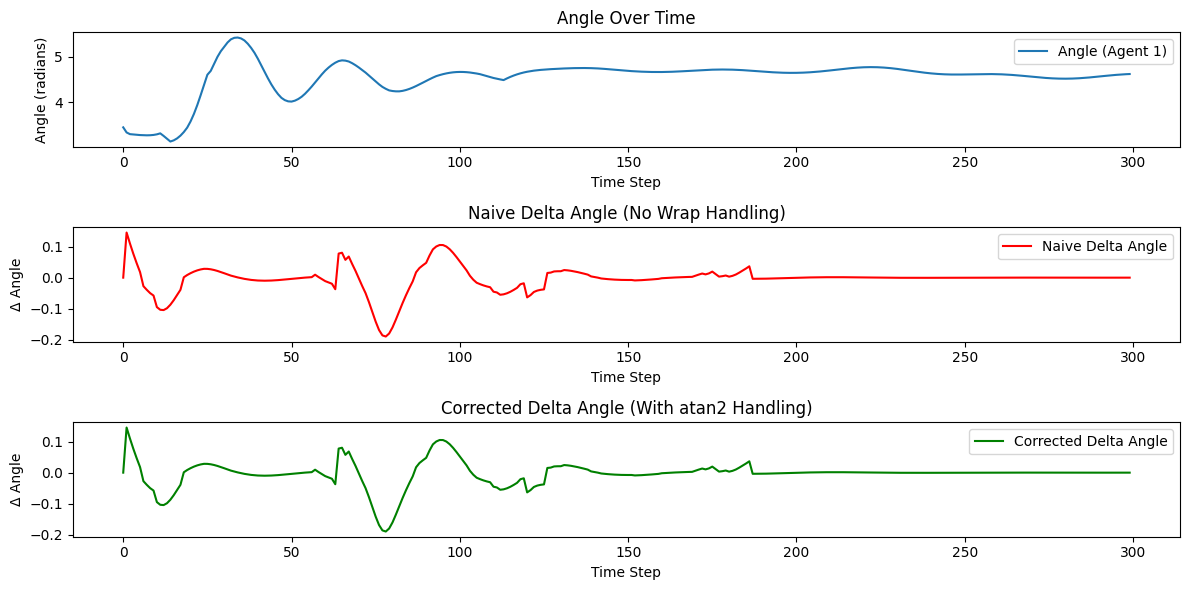

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Compute incorrect delta angles (naive subtraction)
naive_delta_angle = np.zeros_like(angles)
naive_delta_angle[1:] = angles[1:] - angles[:-1]

# Compute corrected delta angles (using atan2)
corrected_delta_angle = np.zeros_like(angles)
corrected_delta_angle[1:] = np.arctan2(np.sin(angles[1:] - angles[:-1]), np.cos(angles[1:] - angles[:-1]))

# Plot angles over time
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(angles[:, 3, 0], label="Angle (Agent 1)")
plt.xlabel("Time Step")
plt.ylabel("Angle (radians)")
plt.title("Angle Over Time")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(naive_delta_angle[:, 1, 0], label="Naive Delta Angle", color="red")
plt.xlabel("Time Step")
plt.ylabel("Δ Angle")
plt.title("Naive Delta Angle (No Wrap Handling)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(corrected_delta_angle[:, 1, 0], label="Corrected Delta Angle", color="green")
plt.xlabel("Time Step")
plt.ylabel("Δ Angle")
plt.title("Corrected Delta Angle (With atan2 Handling)")
plt.legend()

plt.tight_layout()
plt.show()


In [79]:
angles_df = pd.DataFrame(angles.reshape(len(grouped), -1))  # col: agent number; row: timestep
# delta_angle_df = pd.DataFrame(delta_angle.reshape(len(grouped), -1))  # Each column is an agent's deltaAngle

In [80]:
angles_df.head(30)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.937776,4.489234,5.236482,3.450525,5.389784,4.466402,1.816786,5.830725,3.391650,5.492087,...,3.814932,0.675097,0.389246,0.284185,0.805900,3.236701,3.956260,3.737987,4.124229,0.687666
1,1.937776,4.634542,5.236482,3.338012,5.440627,4.494933,1.848828,5.830725,3.408552,5.492087,...,3.750298,0.675097,0.436413,0.284185,0.782262,3.236701,3.956260,3.951367,4.124229,0.687666
2,1.937776,4.744550,5.236482,3.300627,5.462534,4.507693,1.884060,5.830725,3.423711,5.492087,...,3.664272,0.675097,0.480000,0.284185,0.766809,2.833703,3.956260,4.145952,4.124229,0.687666
3,1.816858,4.821488,5.236482,3.293478,5.458939,4.492811,1.929951,5.830725,3.439292,5.492087,...,3.540498,0.675097,0.419465,0.284185,0.880655,2.731811,3.956260,4.317834,4.124229,0.687666
4,1.753624,4.867859,5.236482,3.286401,5.378509,4.467499,2.022799,5.830725,3.457484,5.492087,...,3.340179,0.675097,0.376948,0.284185,1.060718,2.627755,3.956260,4.464361,4.124229,0.687666
5,1.682915,4.885669,5.236482,3.280653,5.370162,4.410646,2.158647,5.830725,3.507405,5.492087,...,3.340179,0.675097,0.349466,0.284185,1.233075,2.517240,3.956260,4.584677,4.124229,0.687666
6,1.620140,4.858240,5.236482,3.276674,5.340307,4.306006,2.355877,5.830725,3.546099,5.492087,...,3.340179,0.675097,0.334965,0.284185,1.441564,2.396090,3.956260,4.751135,4.124229,0.687666
7,1.577229,4.818968,5.236482,3.275091,5.295571,4.133308,2.624773,5.830725,3.587081,5.492087,...,3.340179,0.675097,0.332094,0.284185,1.634087,2.260172,3.956260,4.894298,4.124229,0.687666
8,1.550601,4.769061,5.236482,3.276922,5.229215,3.884039,2.943439,5.830725,3.625803,5.492087,...,3.340179,0.675097,0.339952,0.284185,1.816455,2.105682,3.956260,5.017000,4.124229,0.687666
9,1.538655,4.711401,5.236482,3.283437,5.133285,3.584698,3.257740,5.830725,3.663404,5.492087,...,3.340179,0.675097,0.357772,0.284185,1.994016,1.929961,3.956260,5.121420,4.124229,0.687666


In [81]:
# delta_angle_df.head(10)

In [82]:
np.arctan2(-0.09105, 0.9958)

np.float64(-0.09118049177939738)

## Define Model

In [83]:
# define nn
hidden_size_1 = 16
hidden_size_2 = 8
hidden_size_3 = 4

model = nn.Sequential(
    nn.Linear(13, hidden_size_1),
    nn.ReLU(),
    nn.Linear(hidden_size_1, hidden_size_1),
    nn.ReLU(),
    nn.Linear(hidden_size_1, hidden_size_2),
    nn.ReLU(),
    nn.Linear(hidden_size_2, 1)
)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Define Model

In [93]:
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor.view(-1, 13))
    loss = criterion(outputs, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/1000], Loss: 0.000070
Epoch [20/1000], Loss: 0.000069
Epoch [30/1000], Loss: 0.000068
Epoch [40/1000], Loss: 0.000068
Epoch [50/1000], Loss: 0.000067
Epoch [60/1000], Loss: 0.000066
Epoch [70/1000], Loss: 0.000065
Epoch [80/1000], Loss: 0.000065
Epoch [90/1000], Loss: 0.000064
Epoch [100/1000], Loss: 0.000065
Epoch [110/1000], Loss: 0.000167
Epoch [120/1000], Loss: 0.000109
Epoch [130/1000], Loss: 0.000092
Epoch [140/1000], Loss: 0.000068
Epoch [150/1000], Loss: 0.000063
Epoch [160/1000], Loss: 0.000060
Epoch [170/1000], Loss: 0.000059
Epoch [180/1000], Loss: 0.000058
Epoch [190/1000], Loss: 0.000057
Epoch [200/1000], Loss: 0.000057
Epoch [210/1000], Loss: 0.000056
Epoch [220/1000], Loss: 0.000055
Epoch [230/1000], Loss: 0.000055
Epoch [240/1000], Loss: 0.000054
Epoch [250/1000], Loss: 0.000054
Epoch [260/1000], Loss: 0.000053
Epoch [270/1000], Loss: 0.000052
Epoch [280/1000], Loss: 0.000052
Epoch [290/1000], Loss: 0.000053
Epoch [300/1000], Loss: 0.000214
Epoch [310/1000], L

## Evaluate the model

In [94]:
with torch.no_grad():
    y_pred = model(X_test_tensor.view(-1, 13))
    test_loss = criterion(y_pred, y_test_tensor.view(-1, 1))
    print(f'Test Loss: {test_loss.item():.6f}')
    print(y_pred)

Test Loss: 0.000130
tensor([[3.3555],
        [3.3467],
        [5.5882],
        ...,
        [3.8027],
        [1.4769],
        [0.6886]])


## Save the model

In [95]:
torch.save(model, '../models/20250418_v1')